In [45]:
# import the libraries
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Unzip the merged data
!unzip "merged_data.zip"

Archive:  merged_data.zip
  inflating: merged_data             


In [13]:
# read the data
data=pd.read_csv("merged_data")

<ipython-input-13-b1d1133be03a>:1: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("merged_data")


In [17]:
# Change it to datetime format
data['date']=pd.to_datetime(data['date'])

In [18]:
# Set the date column as the index
data.set_index('date', inplace=True)
data.sort_index(inplace=True)

In [19]:
data

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,...,description,transferred,year,month,week,quarter,day_of_week,day_of_year,day_of_month,week_of_year
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,...,Primer dia del ano,False,2013,1,1,1,Tuesday,1,1,1
2013-01-01,1,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,...,Primer dia del ano,False,2013,1,1,1,Tuesday,1,1,1
2013-01-01,2,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,...,Primer dia del ano,False,2013,1,1,1,Tuesday,1,1,1
2013-01-01,3,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,...,Primer dia del ano,False,2013,1,1,1,Tuesday,1,1,1
2013-01-01,4,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,...,Primer dia del ano,False,2013,1,1,1,Tuesday,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,...,Fundacion de Riobamba,False,2017,8,33,3,Tuesday,227,15,33
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,...,Fundacion de Riobamba,False,2017,8,33,3,Tuesday,227,15,33
2017-08-15,3000885,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,...,Fundacion de Riobamba,False,2017,8,33,3,Tuesday,227,15,33


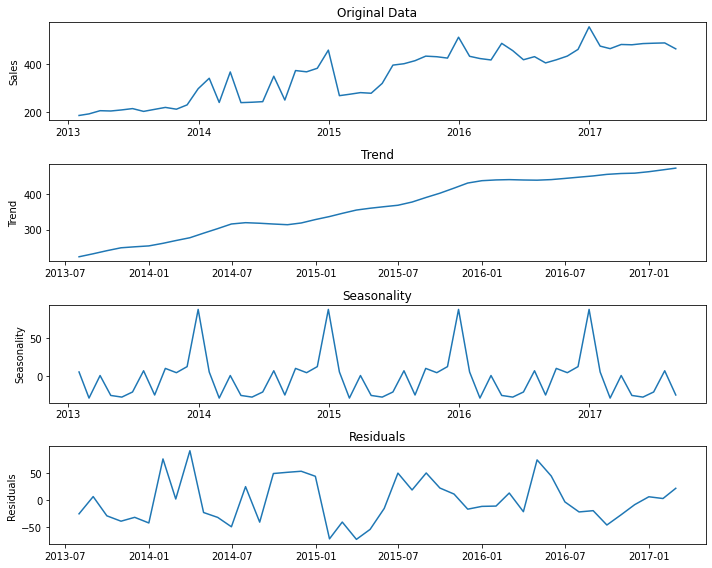

In [24]:
# Resample the data to a lower frequency (e.g., monthly)
data_resampled = data.resample('M').mean()

# Decompose the time series into trend, seasonality, and residuals
decomposition = sm.tsa.seasonal_decompose(data_resampled['sales'], model='additive')

# Plot the trend, seasonality, and residuals
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.set_ylabel('Sales')
ax1.plot(data_resampled['sales'])
ax1.set_title('Original Data')
 
ax2.set_ylabel('Trend')
ax2.plot(decomposition.trend)
ax2.set_title('Trend')

ax3.set_ylabel('Seasonality')
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonality')

ax4.set_ylabel('Residuals')
ax4.plot(decomposition.resid)
ax4.set_title('Residuals')

plt.tight_layout()
plt.show()

In [25]:
# To capture the weekday information
weekday_dummies = pd.get_dummies(data.index.dayofweek, prefix='weekday')

In [26]:

# Merge the time dummy variables with the original data
weekday_dummies.index = data.index
data = pd.concat([data, weekday_dummies], axis=1)

# Create lagged variables for sales
for i in range(1, 8):
    data['lag_{}'.format(i)] = data['sales'].shift(i)

# Remove any rows with missing values
data.dropna(inplace=True)

In [27]:
data.head()

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,...,weekday_4,weekday_5,weekday_6,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,73062,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,97.01,...,0,0,0,11.0,0.0,0.0,60.0,331.284,0.000,0.000
2013-02-11,73063,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,97.01,...,0,0,0,0.0,11.0,0.0,0.0,60.000,331.284,0.000
2013-02-11,73064,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,97.01,...,0,0,0,0.0,0.0,11.0,0.0,0.000,60.000,331.284
2013-02-11,73065,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,97.01,...,0,0,0,0.0,0.0,0.0,11.0,0.000,0.000,60.000
2013-02-11,73066,1,BOOKS,0.0,0,Quito,Pichincha,D,13,97.01,...,0,0,0,172.0,0.0,0.0,0.0,11.000,0.000,0.000


In [36]:

from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
data['family'] = le.fit_transform(data['family'])


In [37]:
data = data.select_dtypes(exclude=['object'])

In [38]:
data

,id,store_nbr,family,sales,onpromotion,store_type,cluster,dcoilwtico,transactions,transferred,...,weekday_4,weekday_5,weekday_6,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,73062,1,0,0.000,0,0,13,97.01,396.0,False,...,0,0,0,11.000,0.000,0.000,60.000,331.284,0.000,0.000
2013-02-11,73063,1,1,0.000,0,1,13,97.01,396.0,False,...,0,0,0,0.000,11.000,0.000,0.000,60.000,331.284,0.000
2013-02-11,73064,1,2,0.000,0,2,13,97.01,396.0,False,...,0,0,0,0.000,0.000,11.000,0.000,0.000,60.000,331.284
2013-02-11,73065,1,3,172.000,0,3,13,97.01,396.0,False,...,0,0,0,0.000,0.000,0.000,11.000,0.000,0.000,60.000
2013-02-11,73066,1,4,0.000,0,4,13,97.01,396.0,False,...,0,0,0,172.000,0.000,0.000,0.000,11.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,28,438.133,0,28,6,47.57,2155.0,False,...,0,0,0,6.000,6.000,522.000,449.228,11.000,25.000,6.000
2017-08-15,3000884,9,29,154.553,1,29,6,47.57,2155.0,False,...,0,0,0,438.133,6.000,6.000,522.000,449.228,11.000,25.000
2017-08-15,3000885,9,30,2419.729,148,30,6,47.57,2155.0,False,...,0,0,0,154.553,438.133,6.000,6.000,522.000,449.228,11.000


### Linear Regression

In [108]:
X=data.drop(columns=['sales']).copy()
y = data['sales'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [60]:
y_pred=pd.DataFrame(y_pred)
y_pred=y_pred.reset_index()
y_pred=y_pred.rename(columns={0:'sales'})
y_pred=y_pred.groupby("date")['sales'].sum().reset_index()

,date,sales
0,2013-02-11,421702.042618
1,2013-02-12,372091.630836
2,2013-04-01,651917.322402
3,2013-04-12,404634.825331
4,2013-04-29,540250.015758
...,...,...
161,2017-07-24,873572.745455
162,2017-07-25,830643.028561
163,2017-08-10,593430.290495
164,2017-08-11,808911.217391


In [86]:
y_train=pd.DataFrame(y_train)
y_train=y_train.reset_index()
y_train=y_train.rename(columns={0:'sales'})
y_train=y_train.groupby("date")['sales'].sum().reset_index()


In [87]:
y_train

,date,sales
0,2013-02-11,278627.588926
1,2013-02-12,308800.790912
2,2013-04-01,428816.447912
3,2013-04-12,314394.967035
4,2013-04-29,328795.874018
...,...,...
161,2017-07-24,816564.327096
162,2017-07-25,713581.632609
163,2017-08-10,651386.911970
164,2017-08-11,826373.722022


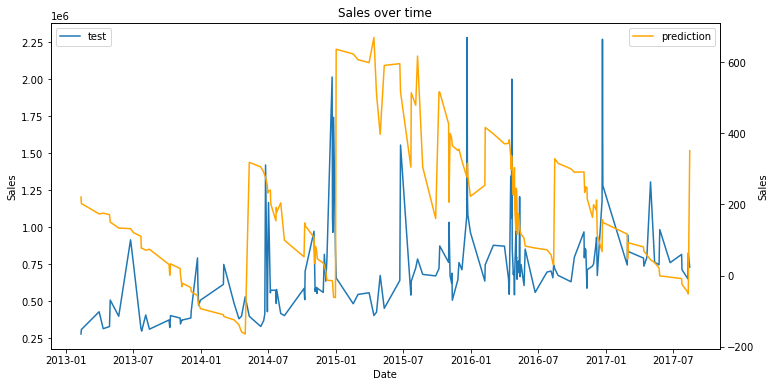

In [69]:
# sales train data vs predicted sales train data

# Convert Date column to datetime format
y_train['date'] = pd.to_datetime(y_train['date'])
y_pred['date'] = pd.to_datetime(y_train['date'])

# Set plot size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the first line plot
ax.plot(y_train['date'], y_train['sales'], label='test')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales over time')

# Create a second y-axis and plot the second line plot
ax2 = ax.twinx()
ax2.plot(y_pred['date'], y_pred['sales'], color='orange', label='prediction')
ax2.set_ylabel('Sales')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


The linear regression results were not satisfactory, therefore we utilized a combination of linear and xgb regression to create an ensemble model.

Ensemble model using Xgb and Linear regression

In [101]:

import xgboost as xgb

X=data.drop(columns=['sales']).copy()
y = data['sales'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit and predict
model = xgb.XGBRegressor(verbosity=0) # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred1 = pd.Series(model.predict(X_train), index=y_train.index)
y_fore1 = pd.Series(model.predict(X_test), index=y_test.index)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

In [102]:
y_test

date
2016-08-10      38.000
2016-08-10    1744.000
2016-08-10    2068.000
2016-08-10     319.906
2016-08-10     404.000
                ...   
2017-08-15     438.133
2017-08-15     154.553
2017-08-15    2419.729
2017-08-15     121.000
2017-08-15      16.000
Name: sales, Length: 64509, dtype: float64

In [109]:
y_p=y_pred1+y_pred
y_f=y_fore1+y_fore

In [78]:
y_p=pd.DataFrame(y_p)
y_p=y_p.reset_index()
y_p=y_p.rename(columns={0:'sales'})
y_p=y_p.groupby("date")['sales'].sum().reset_index()


In [118]:
y_p=pd.DataFrame(y_p)
y_p=y_p.reset_index()
y_p=y_p.rename(columns={0:'sales'})
y_p=y_p.groupby("date")['sales'].sum().reset_index()

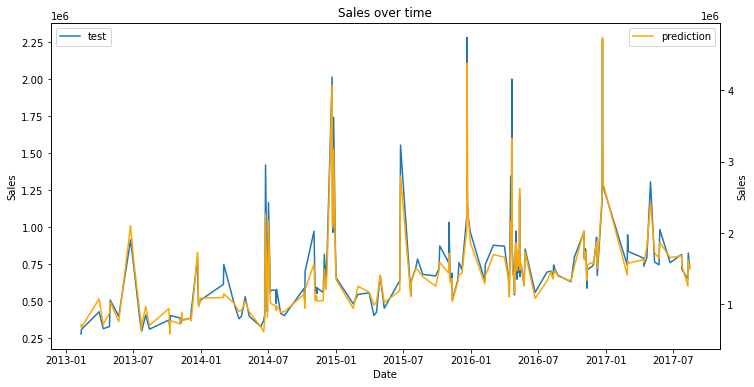

In [88]:
# sales train data vs predicted sales train data

# Convert Date column to datetime format
y_p['date'] = pd.to_datetime(y_p['date'])

# Set plot size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the first line plot
ax.plot(y_train['date'], y_train['sales'], label='test')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales over time')

# Create a second y-axis and plot the second line plot
ax2 = ax.twinx()
ax2.plot(y_p['date'], y_p['sales'], color='orange', label='prediction')
ax2.set_ylabel('Sales')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [110]:
y_f=pd.DataFrame(y_f)
y_f=y_f.reset_index()
y_f=y_f.rename(columns={0:'sales'})
y_f=y_f.groupby("date")['sales'].sum().reset_index()

In [113]:
y_test=pd.DataFrame(y_test)
y_test=y_test.reset_index()
y_test=y_test.rename(columns={0:'sales'})
y_test=y_test.groupby("date")['sales'].sum().reset_index()


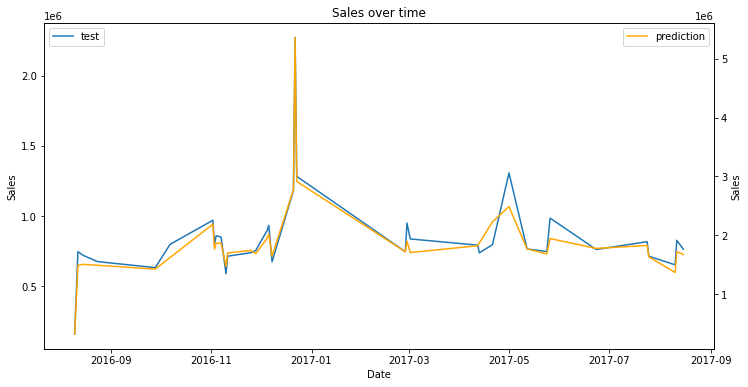

In [115]:
# Test data vs predicted sales data

# Convert Date column to datetime format
y_f['date'] = pd.to_datetime(y_f['date'])

# Set plot size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the first line plot
ax.plot(y_test['date'], y_test['sales'], label='test')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales over time')

# Create a second y-axis and plot the second line plot
ax2 = ax.twinx()
ax2.plot(y_f['date'], y_f['sales'], color='orange', label='prediction')
ax2.set_ylabel('Sales')

# Show legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [117]:
# The MSE for the test data
mean_squared_error(y_test['sales'],y_f['sales'])

14142.32
